# Тестирование метода TAM (Token Activation Map)

## 1. Установка окружения и зависимостей
Клонируем репозиторий, устанавливаем системные библиотеки для рендеринга текста (Latex) и Python-библиотеки.

In [1]:
# 1. Клонируем репозиторий
!git clone https://github.com/xmed-lab/TAM.git

# 2. Устанавливаем системные зависимости для визуализации текста (TexLive)
# Это может занять пару минут, но необходимо для генерации картинок с подписями методом TAM
!sudo apt-get update -q
!sudo apt-get install texlive-xetex -y -q
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super -y -q

# 3. Устанавливаем Python зависимости
%cd TAM
!pip install -r requirements.txt -q

# 4. Доустанавливаем специфичные для Qwen2-VL библиотеки
!pip install qwen-vl-utils git+https://github.com/huggingface/transformers.git accelerate -q

Cloning into 'TAM'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 41 (delta 11), reused 32 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 4.53 MiB | 34.40 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,205 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-

## 2. Импорт библиотек и загрузка модели
Мы будем использовать модель `Qwen/Qwen2-VL-2B-Instruct`. Она оптимизирована и вмещается в память Colab (T4 GPU).

In [4]:
!pip uninstall PyMuPDF

Found existing installation: PyMuPDF 1.26.7
Uninstalling PyMuPDF-1.26.7:
  Would remove:
    /usr/local/bin/pymupdf
    /usr/local/lib/python3.12/dist-packages/fitz/*
    /usr/local/lib/python3.12/dist-packages/pymupdf-1.26.7.dist-info/*
    /usr/local/lib/python3.12/dist-packages/pymupdf/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.12/dist-packages/fitz/.DS_Store
    /usr/local/lib/python3.12/dist-packages/fitz/frontend.py
    /usr/local/lib/python3.12/dist-packages/fitz/tools/__init__.py
    /usr/local/lib/python3.12/dist-packages/fitz/tools/builder.py
    /usr/local/lib/python3.12/dist-packages/fitz/tools/commandline.py
    /usr/local/lib/python3.12/dist-packages/fitz/tools/graphutils.py
    /usr/local/lib/python3.12/dist-packages/fitz/tools/setup_project.py
Proceed (Y/n)? y
  Successfully uninstalled PyMuPDF-1.26.7


In [6]:
!pip install PyMuPDF

  Using cached pymupdf-1.26.7-cp310-abi3-manylinux_2_28_x86_64.whl.metadata (3.4 kB)
Using cached pymupdf-1.26.7-cp310-abi3-manylinux_2_28_x86_64.whl (24.1 MB)


In [7]:
import os
import sys
import torch
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Добавляем путь к репозиторию TAM чтобы импортировать модули
# sys.path.append(os.path.abspath('.'))

from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# Импортируем сам метод TAM из склонированного репозитория
from tam import TAM

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Загрузка модели и процессора
model_name = "Qwen/Qwen2-VL-2B-Instruct"

print("Загрузка модели... (это может занять время)")
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16, # Используем fp16 для экономии памяти GPU
    attn_implementation="eager", # FlashAttention может не работать на T4 без доп. настроек
    device_map="auto"
)

processor = AutoProcessor.from_pretrained(model_name, min_pixels=256*28*28, max_pixels=512*28*28)
print("Модель загружена.")

Using device: cuda
Загрузка модели... (это может занять время)


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Модель загружена.


## 3. Подготовка данных
Возьмем изображение с двумя объектами (например, кот и собака), чтобы проверить, как TAM разделяет внимание модели.

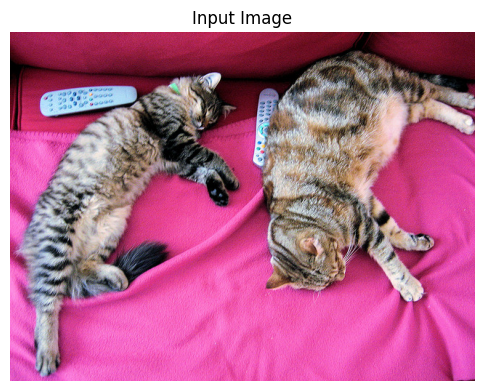

In [9]:
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"

response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# Отобразим исходное изображение
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()

prompt_text = "Describe the animal in the image in detail."

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt_text},
        ],
    }
]

# Подготовка входных данных для модели
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(device)

## 4. Генерация и получение Logits
Для работы метода TAM необходимо получить `output_hidden_states` и затем вычислить `logits` для сгенерированных токенов.

In [10]:
# Запускаем генерацию с сохранением скрытых состояний
print("Генерация ответа...")
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=30, # Ограничим длину для скорости демо
        use_cache=True,
        output_hidden_states=True,  # ---> ВАЖНО для TAM
        return_dict_in_generate=True,
        do_sample=False # Жадное декодирование для воспроизводимости
    )

generated_ids = outputs.sequences
generated_ids_trimmed = [generated_ids[0, inputs.input_ids.shape[1]:]]

# Декодируем и выводим ответ
result_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True)[0]
print(f"\nОтвет модели:\n{result_text}")

# --- Получение Logits для TAM ---
# TAM требует логиты для каждого шага генерации, спроецированные через lm_head
print("Расчет Logits (может занять память)...")
logits_list = []
for feat_tuple in outputs.hidden_states:
    # Берем последний слой (last hidden state)
    last_hidden_state = feat_tuple[-1]
    with torch.no_grad():
        # Проецируем через lm_head модели, чтобы получить логиты
        step_logits = model.lm_head(last_hidden_state)
        logits_list.append(step_logits)

# Проверка формы
print(f"Количество шагов генерации: {len(logits_list)}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Генерация ответа...

Ответ модели:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Расчет Logits (может занять память)...
Количество шагов генерации: 30


Видно, что модель генирирует какие-то галлюцинации вместо описания изображения. Метод не оправдал себя.